In [1]:
%matplotlib inline
import glob
import os
import numpy as np
import numba as nb
import awkward as ak
import matplotlib.pyplot as plt
import uproot
from uproot_methods import TLorentzVectorArray
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from cycler import cycler
import coffea.processor as processor
from dask.distributed import Client
from coffea_casa import CoffeaCasaCluster

In [2]:
fileset = {'tHq': ['root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/3A3BA22C-AA71-2544-810A-6DF4C6BA96FC.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/3AFB1F42-BC6D-D44E-86FD-DB93C83F88FF.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/A37B4B7A-FB5B-484D-8577-40B860D77D23.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/E3C7548E-EE40-BA45-9130-17DF56FBE537.root',
                    'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/F9EFC559-09E9-BB48-8150-9AA8B7F02C1C.root'],
             'tHW': ['root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/2806293E-D1DD-4A49-A274-0CC3BA57BBDF.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/2F19962E-1DFB-A14A-91C2-30B69D5651D3.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/D9744111-ED04-3F47-A52A-C18424F01609.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/THW_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/E4CFA095-E7DB-B449-986D-1A5D21FD1D50.root'],
             'ttW': ['root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/30000/2E92C41D-6F94-F84B-A46B-61EDFFBEFE5B.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/30000/69D60020-75AF-CA42-8D94-99957EEF71DC.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/30000/AB62AEC8-6F15-1947-9E22-0059E196EBE5.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/30000/EA538168-AF02-774C-9648-9BF72471384D.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/2CF42572-162F-F14F-B7CA-96DABCD83589.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/4B8C7791-6DFF-5748-B6AF-7FE0F6B5CA1D.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/5BF4BF41-CFDB-F447-B034-D806DFE3252C.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/794E6532-E576-FB41-A23F-CD078AABC85E.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/8102B971-D215-004C-93EE-AE9A6C1907B3.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/EF9DC33E-137A-0640-976B-8C3AC89F534E.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTWJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/FF4BF1D3-A06A-0F44-8458-37984DEA5CAD.root'],
             'ttWJets': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/028BA117-69BE-B74D-9862-2170CA64B11C.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/1ABC137E-5233-044E-B3FE-8574DC6FC943.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/2274637A-76F8-4049-B651-F60817E6F775.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/2E4A4356-C68F-1B4C-A920-656C7F519328.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/3BEEC74F-9E73-1745-BCA2-09E2725C3979.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/80CEEF63-623A-8144-AEE6-0BAEB5BC314B.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/DA330C53-B0BE-A84F-9308-1BBBC38B095C.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/E3EE47DE-4DBB-FC48-84AB-4F9C26B9CCE8.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttWJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/F597371F-E866-6B47-A185-268F927E3372.root'],
            'ttZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/40000/5B1499CC-2B27-4F44-95BD-7B1C9907ACCD.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/40000/CDA99173-3C05-1A47-AE70-587B44E6348B.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/60000/28C6248C-D55F-8044-BDFB-696BAC0FE329.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/60000/F8A11DF6-4013-6F4C-BBE9-1759933FF20F.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/110000/308939D7-DA54-E949-958D-7B495723DB4C.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/110000/3A1F9F01-E4BC-A347-8D57-8DBFAA890EAB.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/110000/BF1A0533-7A59-A04C-9A6C-6A5EA4697A06.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/191705EA-1891-6942-8CD2-CD70B0E58893.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/27BD2647-8A2F-7C45-964F-F0277A0A011D.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/56608BD3-2A0E-1941-8386-F498EEC16A61.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/7D898E0C-0752-B948-8BA7-7016BD151BD2.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/97637969-BD4B-0640-8158-17722CB9F631.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/9BEAB5BD-5C7E-B54A-B42E-D81FA4B30A2B.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/C7073B6B-C69E-1B42-B378-7FAC8FF4E856.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext2-v1/120000/FF986F85-71C4-064D-9759-B0C1ACAE9454.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/34275A2F-313A-6D4D-A7EC-DD18BF9C413B.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/392B4635-E8FF-924C-A5B5-51D19C670F69.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/4C139140-A677-AB49-9DF9-5BBF4FA850D2.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/80416EBE-074F-5C4A-AE5F-6403A9F9E9D9.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/96F276D6-1C38-9F4F-93CE-503B860AB550.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/A1AD2099-D5D6-7A47-AEB6-562F68B04441.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTZToLLNuNu_M-10_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext3-v1/130000/AAD8B507-CEC2-CE44-9B23-822A451F426C.root'],
            'ttZJets': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/12857BB7-7239-B94A-A890-7CB3C79BD057.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/193EA450-873A-3047-BA69-3B1D1EABB771.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/21167A9A-2FDD-C240-AF27-FAA935B0057C.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/576C9504-E9B2-484C-88DB-1F087D4BA6A3.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/5C781945-9A98-7F44-B397-F806603C9A01.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/69E6121A-F0DC-8043-991A-049199E4BCC4.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/72EF6B33-D0AA-6540-BA4A-A760E8194589.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/8B2D64F4-D873-124B-AE6A-0503FF7A0427.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/B865F28C-D9B3-0944-8E01-D0D3B01C4F26.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/C2C66219-4FAA-4C4E-95FB-CA259749AAA4.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/DD8A6F4F-52CF-9142-B264-B402A94CFD09.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ttZJets_13TeV_madgraphMLM/NANOAODSIM/Nano1June2019_102X_mcRun2_asymptotic_v7-v1/40000/E0D9AB84-E0BF-0C49-9B2E-E003587FF335.root'],
            'ttH': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/05371F7D-77DA-FD4E-BF1F-9C4B6C7B2BF4.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/1097F45B-C2CC-034A-98D5-6A2C38F9E957.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/144E050B-AC6C-5046-B9BF-3CB1045651D1.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/1F8A2052-DD4D-F24B-AEF7-C6C8DB5E42AC.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/2BDDFDC0-1D0E-4141-BCB6-98FDE981E522.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/3D3743BD-A2B7-F34E-BBD3-FE98A055B935.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/70319D0B-46D5-6840-9FA3-49B990C6E117.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/7CF51AAB-6C37-F84E-B091-48C8217EE65E.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/90463B9A-2AB6-1D4E-9D7F-4E6AA6B4500C.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/A922DC1E-905C-0240-81D7-8470159370D4.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/C6BD7A39-4592-F84F-99FB-52C1BBC3F066.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/EE7FEAE7-21B8-4547-A0C7-589B3DDA0704.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/100000/F5A64CA8-059C-4D46-A2C4-9B679A4B911F.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ttHJetToNonbb_M125_13TeV_amcatnloFXFX_madspin_pythia8_mWCutfix/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/120000/83CB02F7-FFA9-CD47-9EE6-4D444843595E.root'],
            'WZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/120000/222071C0-CF04-1E4B-B65E-49D18B91DE8B.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/120000/7EC09E9F-A061-6D46-83DB-E91A8479CD7A.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/120000/9FA39757-C2AB-F34E-A2E8-3D728B605FD1.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/120000/E539344F-0815-064E-BFB2-14D265A460FA.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/0571F847-7582-0D43-A65D-BB1DF150BE77.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/1875117C-8380-0C45-A701-B221443E9010.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/23490416-1F0E-364F-B5D9-7F7C92360277.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/423A6069-CE53-A94F-8D9F-75342F9F9273.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/42816FAA-2580-7146-93BE-C9482FC56E5F.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/4DCA8EC5-BC5C-3447-8A91-C21142F57775.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/4F6290B2-15A7-C840-8544-26FBA7D62129.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/62527AE1-E838-BF44-AA33-C145C74F2196.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/64F0D9CB-C675-3F49-ACE2-E06CD5CFFA13.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/669C5D12-E263-0E41-9F49-B277198FA882.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/788641E9-D641-0F40-AC0D-69E335F7E04D.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/A2DCB4B2-9A3B-6049-B845-8BC13C623736.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/B5189B28-6A9D-9240-A943-830C76F1C4CE.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/CFBDFA7E-FA6A-9E40-976A-5E2CAE843CE2.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/D52DFC49-0016-2941-BEB6-7958728B782E.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/DD34D24C-D3E4-6046-AA01-EDF356AC83CB.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/E4035DC3-ACD2-0440-805F-F8C46406E0A0.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/110000/FED349E0-72BB-7E4F-B776-F9BB8C278B27.root'],
            'ZZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/010B000A-0883-064B-B250-A6159DB2603A.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/1B4E5034-DD6A-DB40-882D-20B5C42A9722.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/462F4643-6F37-EA42-8F6C-90B91C23A731.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/465A6EA9-E768-E642-8A73-B27E21BD3595.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/46E99F08-CB4C-914F-9CF0-1A9E7DCE8081.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/73D0D73F-E72D-E649-8772-2BECC3D296D7.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/773BDDB0-D100-DA4B-8522-17EB71265BEE.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/D08D925B-BA30-3642-9995-F165FC2542D7.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/DC582D74-81EF-504C-8342-08D42BB17C38.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/ZZTo4L_13TeV_powheg_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/30000/FD274208-7DF0-3245-945F-87B17415142E.root'],
            'ZZZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ZZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/37FA68CC-B841-7D41-994C-645CFA4BA227.root'],
            'WWZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/WWZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/8034D852-4E18-F441-B1B7-3A4BA82B8963.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WWZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/70000/EE791322-C349-A14A-B49A-75BDAA03482E.root'],
            'WZZ': ['root://xcache//store/mc/RunIISummer16NanoAODv5/WZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/4359B067-2773-4D48-A235-CD33C3A20AD9.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/50D0F171-4A01-644A-A1D9-6BF1D915DF2A.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/WZZ_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/61EDBB45-0A24-1847-9FD6-222D7D8D6AF3.root'],
            'tttt': ['root://xcache//store/mc/RunIISummer16NanoAODv5/TTTT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/E23424C4-B553-114D-A9F2-9E2F21D641F6.root',
                     'root://xcache//store/mc/RunIISummer16NanoAODv5/TTTT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/ED3B459F-A945-C847-9B80-B847C3487049.root'],
            'WpWp': ['root://xcache//store/mc/RunIISummer16NanoAODv5/WpWpJJ_EWK-QCD_TuneCUETP8M1_13TeV-madgraph-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/120000/025F6345-BE37-DF45-B582-25EA8300B4E8.root'],
            'WGToLNuG': ['root://xcache//store/mc/RunIISummer16NanoAODv5/WGToLNuG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/60000/1C9A5B42-59F6-BE46-B6A5-FCFBB332800D.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/WGToLNuG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/60000/3EDF906E-8031-134B-A90B-A4D514534E2C.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/WGToLNuG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/60000/4A38A79D-C3E8-6642-A769-DF7DFD1EB5F8.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/WGToLNuG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/60000/8F31680D-1759-5A41-9B6C-0BC14DCC2DCB.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/WGToLNuG_TuneCUETP8M1_13TeV-madgraphMLM-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/60000/D5C66F81-4B6F-B147-9E14-65B72102C938.root'],
            'ZGTo2LG': ['root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/00169085-1173-174A-88D7-DF8C05E63B86.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/0D5754A1-90DD-C44D-8F22-C4D1D25DC8C6.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/21184738-5366-7544-BEC1-F6A553821938.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/33FB9844-B072-3046-9499-DA3AB42E1D2D.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/4970C91E-D60F-6B42-A55C-20569AFAA431.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/701DFC56-C64E-2449-A765-3BCEF02B991D.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/8217CFFF-03A7-7E4D-8C1A-8C0EA798BD82.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/91A1637B-CDE3-F940-96D2-E557F3E20F7E.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/9CAA7F23-A5E5-DB40-A776-068209875DDA.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/B2D94295-780F-AA4C-9A98-FB682EC1F910.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/B53D3104-B052-F24D-ADF2-9026402AFDA8.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/D8B42B2C-1BAA-0F4D-88E8-F03E23CD3701.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/EAD6568E-3035-3A4C-99A9-10F6635C1000.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/EB5065C4-7B33-9A4F-AF54-B80EFF266AC2.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/EDAA08F5-3220-424F-8036-2259BDC63179.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/ZGTo2LG_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/260000/F2CAD07A-CA17-B645-B364-0E9CB98715B8.root'],
            'TGJets': ['root://xcache//store/mc/RunIISummer16NanoAODv5/TGJets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/240000/634ABFF2-03BF-ED48-90CF-1ED79CAEECC2.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TGJets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/240000/999FCE98-7A19-1F4D-99C4-B055C58887DC.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TGJets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/240000/CD355648-3704-FB45-8F3B-125E390C0AEC.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TGJets_TuneCUETP8M1_13TeV_amcatnlo_madspin_pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/00C95E31-FFBA-4C42-8603-066FAB92542A.root'],
            'TTGJets': ['root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/22881651-BBF4-4E49-9000-CB054643A04E.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/3DA57B87-3A1E-E340-B465-1B6DA3278FBA.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/4588AAE8-B596-DA49-834B-046CC2565897.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/5DAC0107-F368-FE49-A2D6-902CB848CB63.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/8DA9E6B2-789A-B740-9F97-C18ADA0A56D0.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/A2AC3FF8-8A99-054D-9FAA-B8742C4D2508.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/A38A9608-2268-0D43-92AE-32DD986767FB.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/B0718C55-B1E7-6148-885E-12323306D998.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/B479B885-9336-5645-AC4E-233CAD65FE30.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/B486E2A0-1FEF-7F4C-8E33-7D8D32378206.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/BAD51EE9-58C2-DF4D-B937-3694B4D42783.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/CD4456D4-22C1-7942-8F71-C0443FEADBC2.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/EBC0FD8D-565D-0A44-B2DE-AFC80D2D4C7D.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7_ext1-v1/250000/F84B0880-61E2-0C4B-BA45-4483B6D1ED27.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/046AFA0D-DA2F-7C4F-81AD-668616A5A08A.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/2F8FAEDA-96E0-E948-A5DF-12B25149DBFA.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/6969756B-8B3D-C445-98EC-B2AB93043443.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/A714BF72-C90E-3B4B-AD81-C66F2B0FBDCB.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/BFA217F6-B261-8B44-9261-E09C97E6E286.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/C4551934-5EBD-3C4C-AE80-AC2F6F6E12CD.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/EA5D2DC1-38B4-914E-B3FF-308FD4A24B94.root',
                         'root://xcache//store/mc/RunIISummer16NanoAODv5/TTGJets_TuneCUETP8M1_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/250000/ECA16C69-E6C8-794C-A3D6-D01EBB5E1922.root'],
          }

In [3]:
from itertools import combinations

# This is a helper function which adds muon (0) and electron (1) identifiers to a stacked lepton JaggedArray.
def make_labeled_p4(x, indices, itype):
    p4 = TLorentzVectorArray.from_ptetaphim(x.pt, x.eta, x.phi, x.mass)
    return ak.JaggedArray.zip(p4=p4,
                              ptype=itype*x.pt.ones_like().astype(np.int),
                              pidx=indices,
                              charge=x.charge)

# This generates a stacked lepton JaggedArray, allowing combination of both muons and electrons for computations across flavor.
def stack_leptons(muons, electrons):
    # Construct new lepton indices within every event array.
    muons_indices = ak.JaggedArray.fromoffsets(muons.pt.offsets, 
                                             np.arange(0, muons.pt.content.size)) - muons.pt.offsets[:-1]
    electrons_indices = ak.JaggedArray.fromoffsets(electrons.pt.offsets, 
                                             np.arange(0, electrons.pt.content.size)) - electrons.pt.offsets[:-1]
    # Assign 0/1 value depending on whether lepton is muon/electron.
    muons_p4 = make_labeled_p4(muons, muons_indices, 0)
    electrons_p4 = make_labeled_p4(electrons, electrons_indices, 1)
    # Concatenate leptons.
    stacked_p4 = ak.concatenate((muons_p4, electrons_p4), axis=1)
    
    return stacked_p4

# Helper function which takes a pair, tells you if it is an OSSF with |m_ll - m_z| < 15. Reject these events.
def ossf_zmass_check(dileptons):
    return ((dileptons.i0.charge != dileptons.i1.charge) & 
            (np.abs(91.18 - (dileptons.i0 + dileptons.i1).mass) < 15.)).any()

# This is a helper function which adds up the transverse momentum of two leptons from their x and y components.
@nb.njit()
def ptAddition(l1_px, l1_py, l2_px, l2_py):
    return np.sqrt((l1_px + l2_px)**2 + (l1_py + l2_py)**2)

# This takes as input values from the trilepton channel and outputs an array with del(phi) between the two highest sslps.
def channel_dphi_ssp(e_starts, e_stops, mu_starts, mu_stops,
                     e_px, e_py, e_phi, mu_px, mu_py, mu_phi, 
                     e_charge, mu_charge):
    dphi = np.zeros(e_starts.size)
    dphi.fill(-np.inf)
    for e_start, e_stop, mu_start, mu_stop, i in zip(e_starts, e_stops, mu_starts, mu_stops, range(0, e_starts.size)):
        event_px = np.concatenate((e_px[e_start:e_stop], mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((e_py[e_start:e_stop], mu_py[mu_start:mu_stop]))
        event_phi = np.concatenate((e_phi[e_start:e_stop], mu_phi[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))
        maxpt = -np.inf
        pair = (None, None)
        for combination in np.array(list(combinations(np.argsort(event_px), 2))):
            if (np.abs(event_charge[combination[0]] + event_charge[combination[1]]) == 2):
                pair_pt = ptAddition(event_px[combination[0]], event_py[combination[0]], event_px[combination[1]], event_px[combination[1]])
                if pair_pt > maxpt:
                    maxpt = pair_pt
                    pair = (combination[0], combination[1])
        if pair != (None, None):
            dphi[i] = np.abs(event_phi[pair[0]] - event_phi[pair[1]])
    return dphi[np.invert(np.isinf(dphi))]

# This take as input values from  a cross-lepton channel and outputs the eta difference of the closest leptons (in eta) to each event's most forward jet.
def channel_fwdeta_jetlep(e_starts, e_stops, mu_starts, mu_stops,
                          jet_maxeta, e_eta, mu_eta):
    deta = np.zeros(e_starts.size)
    deta.fill(-np.inf)
    for e_start, e_stop, mu_start, mu_stop, i in zip(e_starts, e_stops, mu_starts, mu_stops, range(0, e_starts.size)):
        jet = jet_maxeta[i]
        event_eta = np.concatenate((e_eta[e_start:e_stop], mu_eta[mu_start:mu_stop]))
        deta[i] = np.min(np.abs(jet - event_eta))
    return deta

In [4]:
class SignalProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        lll_3rdLepton_pT_axis = hist.Bin("lll_3rdLepton_pT", "3rd Lepton $p_T$ [GeV]", 18, 0, 90)
        lll_fwdJet_leadbJet_axis = hist.Bin("lll_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 18, 0, 6)
        lll_fwdJet_subleadbJet_axis = hist.Bin("lll_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 18, 0, 6)
        lll_fwdJet_closestLepton_axis = hist.Bin("lll_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 18, 0, 6)
        lll_highpT_sslp_axis = hist.Bin("lll_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 18, 0, 3.5)
        lll_jetMaxEta_axis = hist.Bin("lll_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 25)", 18, 0, 5)
        lll_minDelR_axis = hist.Bin("lll_minDelR", "Minimum $\Delta$ R between any two leptons", 18, 0, 4)
        lll_NJetMedium_axis = hist.Bin("lll_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 6, 2, 8)
        lll_NJetNonCSVMedium_axis = hist.Bin("lll_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 7, 1, 8)        
        lll_TotalCharge_axis = hist.Bin("lll_TotalCharge", "Total Lepton Charge", 5, -2, 3)
        
        mumu_subleadLepton_pT_axis = hist.Bin("mumu_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 18, 0, 144)
        mumu_fwdJet_leadbJet_axis = hist.Bin("mumu_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 18, 0, 6)
        mumu_fwdJet_subleadbJet_axis = hist.Bin("mumu_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 18, 0, 6)
        mumu_fwdJet_closestLepton_axis = hist.Bin("mumu_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 18, 0, 6)
        mumu_highpT_sslp_axis = hist.Bin("mumu_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 18, 0, 3.5)
        mumu_jetMaxEta_axis = hist.Bin("mumu_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 18, 0, 5)
        mumu_minDelR_axis = hist.Bin("mumu_minDelR", "Minimum $\Delta$ R between any two leptons", 18, 0, 4)
        mumu_NJetMedium_axis = hist.Bin("mumu_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 6, 2, 8)
        mumu_NJetNonCSVMedium_axis = hist.Bin("mumu_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 7, 1, 8)        
        mumu_TotalCharge_axis = hist.Bin("mumu_TotalCharge", "Total Lepton Charge", 5, -2, 3)
        
        emu_subleadLepton_pT_axis = hist.Bin("emu_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 18, 0, 144)
        emu_fwdJet_leadbJet_axis = hist.Bin("emu_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 18, 0, 6)
        emu_fwdJet_subleadbJet_axis = hist.Bin("emu_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 18, 0, 6)
        emu_fwdJet_closestLepton_axis = hist.Bin("emu_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 18, 0, 6)
        emu_highpT_sslp_axis = hist.Bin("emu_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 18, 0, 3.5)
        emu_jetMaxEta_axis = hist.Bin("emu_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 18, 0, 5)
        emu_minDelR_axis = hist.Bin("emu_minDelR", "Minimum $\Delta$ R between any two leptons", 18, 0, 4)
        emu_NJetMedium_axis = hist.Bin("emu_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 6, 2, 8)
        emu_NJetNonCSVMedium_axis = hist.Bin("emu_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 7, 1, 8)        
        emu_TotalCharge_axis = hist.Bin("emu_TotalCharge", "Total Lepton Charge", 5, -2, 3)
        
        ee_subleadLepton_pT_axis = hist.Bin("ee_subleadLepton_pT", "Sub-leading Lepton $p_T$ [GeV]", 18, 0, 144)
        ee_fwdJet_leadbJet_axis = hist.Bin("ee_fwdJet_leadbJet", "$\Delta \eta$ max fwd jet and leading bjet", 18, 0, 6)
        ee_fwdJet_subleadbJet_axis = hist.Bin("ee_fwdJet_subleadbJet", "$\Delta \eta$ max fwd jet and sub-leading bjet", 18, 0, 6)
        ee_fwdJet_closestLepton_axis = hist.Bin("ee_fwdJet_closestLepton", "$\Delta \eta$ max fwd jet and closest lepton", 18, 0, 6)
        ee_highpT_sslp_axis = hist.Bin("ee_highpT_sslp", "$\Delta \Phi$ highest $p_T$ same-sign lepton pair", 18, 0, 3.5)
        ee_jetMaxEta_axis = hist.Bin("ee_jetMaxEta", "max jet $|\eta|$ ($p_T$ > 40)", 18, 0, 5)
        ee_minDelR_axis = hist.Bin("ee_minDelR", "Minimum $\Delta$ R between any two leptons", 18, 0, 4)
        ee_NJetMedium_axis = hist.Bin("ee_NJetMED", "N(jet, $p_T$ > 25, $|\eta|$ < 2.4)", 6, 2, 8)
        ee_NJetNonCSVMedium_axis = hist.Bin("ee_NJetNONMED", "N(jet, $|\eta|$ > 1) non CSV medium", 7, 1, 8)        
        ee_TotalCharge_axis = hist.Bin("ee_TotalCharge", "Total Lepton Charge", 5, -2, 3)
        
        self._accumulator = processor.dict_accumulator({
            'lll_3rdLepton_pT': hist.Hist("Events", dataset_axis, lll_3rdLepton_pT_axis),
            'lll_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, lll_fwdJet_leadbJet_axis),
            'lll_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, lll_fwdJet_subleadbJet_axis),
            'lll_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, lll_fwdJet_closestLepton_axis),
            'lll_highpT_sslp': hist.Hist("Events", dataset_axis, lll_highpT_sslp_axis),
            'lll_jetMaxEta': hist.Hist("Events", dataset_axis, lll_jetMaxEta_axis),
            'lll_minDelR': hist.Hist("Events", dataset_axis, lll_minDelR_axis),
            'lll_NJetMED': hist.Hist("Events", dataset_axis, lll_NJetMedium_axis),
            'lll_NJetNONMED': hist.Hist("Events", dataset_axis, lll_NJetNonCSVMedium_axis),
            'lll_TotalCharge': hist.Hist("Events", dataset_axis, lll_TotalCharge_axis),
            'mumu_subleadLepton_pT': hist.Hist("Events", dataset_axis, mumu_subleadLepton_pT_axis),
            'mumu_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, mumu_fwdJet_leadbJet_axis),
            'mumu_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, mumu_fwdJet_subleadbJet_axis),
            'mumu_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, mumu_fwdJet_closestLepton_axis),
            'mumu_highpT_sslp': hist.Hist("Events", dataset_axis, mumu_highpT_sslp_axis),
            'mumu_jetMaxEta': hist.Hist("Events", dataset_axis, mumu_jetMaxEta_axis),
            'mumu_minDelR': hist.Hist("Events", dataset_axis, mumu_minDelR_axis),
            'mumu_NJetMED': hist.Hist("Events", dataset_axis, mumu_NJetMedium_axis),
            'mumu_NJetNONMED': hist.Hist("Events", dataset_axis, mumu_NJetNonCSVMedium_axis),
            'mumu_TotalCharge': hist.Hist("Events", dataset_axis, mumu_TotalCharge_axis),
            'emu_subleadLepton_pT': hist.Hist("Events", dataset_axis, emu_subleadLepton_pT_axis),
            'emu_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, emu_fwdJet_leadbJet_axis),
            'emu_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, emu_fwdJet_subleadbJet_axis),
            'emu_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, emu_fwdJet_closestLepton_axis),
            'emu_highpT_sslp': hist.Hist("Events", dataset_axis, emu_highpT_sslp_axis),
            'emu_jetMaxEta': hist.Hist("Events", dataset_axis, emu_jetMaxEta_axis),
            'emu_minDelR': hist.Hist("Events", dataset_axis, emu_minDelR_axis),
            'emu_NJetMED': hist.Hist("Events", dataset_axis, emu_NJetMedium_axis),
            'emu_NJetNONMED': hist.Hist("Events", dataset_axis, emu_NJetNonCSVMedium_axis),
            'emu_TotalCharge': hist.Hist("Events", dataset_axis, emu_TotalCharge_axis),
            'ee_subleadLepton_pT': hist.Hist("Events", dataset_axis, ee_subleadLepton_pT_axis),
            'ee_fwdJet_leadbJet': hist.Hist("Events", dataset_axis, ee_fwdJet_leadbJet_axis),
            'ee_fwdJet_subleadbJet': hist.Hist("Events", dataset_axis, ee_fwdJet_subleadbJet_axis),
            'ee_fwdJet_closestLepton': hist.Hist("Events", dataset_axis, ee_fwdJet_closestLepton_axis),
            'ee_highpT_sslp': hist.Hist("Events", dataset_axis, ee_highpT_sslp_axis),
            'ee_jetMaxEta': hist.Hist("Events", dataset_axis, ee_jetMaxEta_axis),
            'ee_minDelR': hist.Hist("Events", dataset_axis, ee_minDelR_axis),
            'ee_NJetMED': hist.Hist("Events", dataset_axis, ee_NJetMedium_axis),
            'ee_NJetNONMED': hist.Hist("Events", dataset_axis, ee_NJetNonCSVMedium_axis),
            'ee_TotalCharge': hist.Hist("Events", dataset_axis, ee_TotalCharge_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        # btag working point numbers, for easy reference.
        loose_wp = 0.5425
        medium_wp = 0.8484

        # Initialize relevant event columns.
        dataset = events.metadata["dataset"]
        jets = events.Jet
        muons = events.Muon
        electrons = events.Electron

        # This is bookkeeping that tracks how many total events there are.
        output['cutflow']['all events'] += events.size
        
        
        
        # # # # # # # # # # #
        # LEPTON SELECTIONS #
        # # # # # # # # # # #
        
        # Here we establish the loose muons array, based on provided cuts.
        loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                      (np.abs(muons.dxy) < 0.05) & 
                      (np.abs(muons.dz) < 0.1) & 
                      (muons.sip3d < 8) &
                      (muons.miniPFRelIso_all < 0.4) &
                      (muons.looseId) &
                      (muons.pt > 5)]
        
        # Tight is loose with additional cuts; build tight array and add cuts.
        tight_muons = loose_muons[(loose_muons.pt > 15) &
                                  (loose_muons.tightCharge > 0) &
                                  (loose_muons.mediumId) &
                                  (loose_muons.mvaTTH > 0.9)]
        
        # This ends up getting referenced a lot. Let's not generate it every time!
        abs_eta = np.abs(electrons.eta)
        
        # Here we establish the loose electrons array, based on provided cuts.
        loose_electrons = electrons[(abs_eta < 2.5) & 
                              (np.abs(electrons.dxy) < 0.05) & 
                              (np.abs(electrons.dz) < 0.1) & 
                              (electrons.lostHits < 2) &
                              (electrons.miniPFRelIso_all < 0.4) &
                              (electrons.pt > 7) &
                              (((electrons.mvaFall17V2noIso > 0) & (abs_eta < 1.479)) | ((electrons.mvaFall17V2noIso > 0.7) & (abs_eta > 1.479) & (abs_eta < 2.5)))]
            
        # Now we build tight from loose, adding in tight's extra cuts.
        # Redefine abs_eta since we're now using loose.
        abs_eta = np.abs(loose_electrons.eta)
        
        tight_electrons = loose_electrons[(loose_electrons.pt > 15) &
                                         (loose_electrons.lostHits == 0) &
                                         (loose_electrons.tightCharge > 0) &
                                         (loose_electrons.convVeto) &
                                         (loose_electrons.mvaTTH > 0.90) &
                                         # Two ranges for sigma_ieie.
                                         (((abs_eta < 1.479) & (loose_electrons.sieie < 0.011)) | 
                                         ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.sieie < 0.03))) &
                                         # Two ranges for H/E
                                         (((abs_eta < 1.479) & (loose_electrons.hoe < 0.1)) | 
                                         ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.hoe < 0.07))) &
                                         # Two ranges for 1/E - 1/p
                                         (((abs_eta < 1.479) & (loose_electrons.eInvMinusPInv < 0.01) & (loose_electrons.eInvMinusPInv > -0.05)) |
                                         ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.eInvMinusPInv < 0.005) & (loose_electrons.eInvMinusPInv > -0.05)))]        
        
        # Don't want any jets below 25 pT.
        jets = jets[(jets.pt > 25)]

        # # # # # # # # # #
        # EVENT SELECTION #
        # # # # # # # # # #
        
        # Loose pre-selection. See definition of stack_leptons above to see how we construct arrays across leptons.
        loose_leptons = stack_leptons(loose_muons, loose_electrons)
        loose_pairs = loose_leptons.argchoose(2)
        loose_pairs_mass = (loose_leptons[loose_pairs.i0].p4 + loose_leptons[loose_pairs.i1].p4).mass
        looseMask = ((loose_pairs_mass >= 12).all() & (loose_pairs_mass.counts > 0))
        
        # Dilepton selection.
        tight_leptons = stack_leptons(tight_muons, tight_electrons)
        tight_pairs = tight_leptons.argchoose(2)
        # Add types to see what kind of pair we have. mu = 0, e = 1, so: mumu = 0, emu = 1, ee = 2.
        tight_types = (tight_leptons[tight_pairs.i0].ptype + tight_leptons[tight_pairs.i1].ptype)
        
        # Respectively; each event should have exactly 1 pair (2 leptons) with same charge
        #               one should have pT > 25 (pT > 15 is guaranteed by lepton selection)
        #               for ee events, check that mass from Z is < 10 to veto possible Z bosons.
        dileptonMask = ((tight_pairs.counts == 1) & (tight_leptons[tight_pairs.i0].charge == tight_leptons[tight_pairs.i1].charge).any()) & ((tight_leptons[tight_pairs.i0].p4.pt > 25) | (tight_leptons[tight_pairs.i1].p4.pt > 25)).any() & ((tight_types < 2) | (np.abs((tight_leptons[tight_pairs.i0].p4 + tight_leptons[tight_pairs.i1].p4).mass - 91.18) > 10)).any()
        
        # Trilepton selection.
        tight_triples = tight_leptons.argchoose(3)
        tight_muon_pairs = tight_muons.choose(2)
        tight_electron_pairs = tight_electrons.choose(2)
        
        # Respectively; we want events with exactly three tight leptons (one triple),
        #               one should have pT > 25, discard if OSSF dileptons are close to the Z mass.
        trileptonMask = (tight_triples.counts == 1) & ((tight_leptons[tight_triples.i0].p4.pt > 25) | (tight_leptons[tight_triples.i1].p4.pt > 25) | (tight_leptons[tight_triples.i2].p4.pt > 25)).any() & (~ossf_zmass_check(tight_muon_pairs)) & (~ossf_zmass_check(tight_electron_pairs))
        
        # Jet masks can be generated much more simply, since we're staying in one collection.
        jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets.btagCSVV2 > medium_wp)).sum() >= 1
        jetMask_loose = (((np.abs(jets.eta) < 2.4) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) & (jets.btagCSVV2 <= loose_wp)).sum() >= 1
        
        # May as well combine all of our masks into one (well, two) big one(s) for easier referencing.
        # Split dileptons and trileptons into separate channels, because it's easier to work with later.
        dilepton_eventMask = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
        trilepton_eventMask = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)
        
        # Dilepton masks.
        tight_ll_e = tight_electrons[dilepton_eventMask].compact()
        tight_ll_mu = tight_muons[dilepton_eventMask].compact()
        
        # Trilepton masks.
        tight_lll_e = tight_electrons[trilepton_eventMask].compact()
        tight_lll_mu = tight_muons[trilepton_eventMask].compact()
        
        # Split dileptons into further channels: ee, mumu, and emu (need two arrays for this one)
        tights_2mu = tight_ll_mu[tight_ll_mu.counts == 2]
        tights_2e = tight_ll_e[tight_ll_e.counts == 2]
        tights_1e = tight_electrons[dilepton_eventMask & tight_electrons.counts == 1]
        tights_1mu = tight_muons[dilepton_eventMask & tight_muons.counts == 1]
        
        # Can't forget to mask our jets after all of that lepton array-building! We want jets that meet either mask requirement.
        jets_3lep = jets[trilepton_eventMask]
        jets_2mu = jets[dilepton_eventMask & (tight_muons.counts == 2)]
        jets_2e = jets[dilepton_eventMask & (tight_electrons.counts == 2)]
        jets_emu = jets[dilepton_eventMask & (tight_muons.counts == 1) & (tight_electrons.counts == 1)]
        
        
        
        # # # # # #
        # OUTPUTS #
        # # # # # #
        
        # Selecting the data that we want.
            # Three-lepton channel
        lll_ee_pairs = tight_electrons[trilepton_eventMask].distincts()
        lll_mumu_pairs = tight_muons[trilepton_eventMask].distincts()
        lll_emu_pairs = tight_electrons[trilepton_eventMask].cross(tight_muons[trilepton_eventMask])  
        lll_3rdLepton_pT = np.asarray([lll_ee_pairs.i0.pt.min(), lll_ee_pairs.i1.pt.min(),
                                       lll_mumu_pairs.i0.pt.min(), lll_mumu_pairs.i1.pt.min(),
                                       lll_emu_pairs.i0.pt.min(), lll_emu_pairs.i1.pt.min()]).min(0)
        output['cutflow']['passing'] += lll_3rdLepton_pT.size
        lll_lightjets = jets_3lep[jets_3lep.btagCSVV2 <= loose_wp]
        lll_jetcross = jets_3lep[jets_3lep.btagCSVV2 > loose_wp].cross(lll_lightjets[lll_lightjets.eta == lll_lightjets.eta.max()])
        lll_fwdJet_leadbJet = lll_jetcross[lll_jetcross.counts >= 1][:, 0]
        lll_fwdJet_leadbJet = np.abs(lll_fwdJet_leadbJet.i0.eta - lll_fwdJet_leadbJet.i1.eta)
        lll_fwdJet_subleadbJet = lll_jetcross[lll_jetcross.counts >= 2][:, 1]
        lll_fwdJet_subleadbJet = np.abs(lll_fwdJet_subleadbJet.i0.eta - lll_fwdJet_subleadbJet.i1.eta)
        lll_fwdJet_closestLepton = channel_fwdeta_jetlep(tight_lll_e.starts, tight_lll_e.stops, tight_lll_mu.starts, tight_lll_mu.stops,
                                              lll_lightjets.eta.max(), tight_lll_e.eta.content, tight_lll_mu.eta.content)
        lll_highpT_sslp = channel_dphi_ssp(tight_lll_e.starts, tight_lll_e.stops, tight_lll_mu.starts, tight_lll_mu.stops,
                                        tight_lll_e.x.content, tight_lll_e.y.content, tight_lll_e.phi.content, tight_lll_mu.x.content, tight_lll_mu.y.content, tight_lll_mu.phi.content,
                                        tight_lll_e.charge.content, tight_lll_mu.charge.content)
        lll_jetMaxEta = np.abs(jets_3lep.eta[jets_3lep.btagCSVV2 <= loose_wp]).max()
        lll_minDelR = np.asarray([lll_ee_pairs.i0.delta_r(lll_ee_pairs.i1).min(),
                                 lll_mumu_pairs.i0.delta_r(lll_mumu_pairs.i1).min(),
                                 lll_emu_pairs.i0.delta_r(lll_emu_pairs.i1).min()]).min(0)
        lll_NJetMED = jets_3lep[(np.abs(jets_3lep.eta) < 2.4)].counts
        lll_NJetNONMED = jets_3lep[(np.abs(jets_3lep.eta) > 1) & (jets_3lep.btagCSVV2 <= loose_wp)].counts
        lll_TotalCharge = tight_lll_e.charge.sum() + tight_lll_mu.charge.sum()
            # mu-mu channel
        mumu_subleadLepton_pT = tights_2mu.pt[:, 1]
        mumu_lightjets = jets_2mu[jets_2mu.btagCSVV2 <= loose_wp]
        mumu_jetcross = jets_2mu[jets_2mu.btagCSVV2 > loose_wp].cross(mumu_lightjets[mumu_lightjets.eta == mumu_lightjets.eta.max()])
        mumu_fwdJet_leadbJet = mumu_jetcross[mumu_jetcross.counts >= 1][:, 0]
        mumu_fwdJet_leadbJet = np.abs(mumu_fwdJet_leadbJet.i0.eta - mumu_fwdJet_leadbJet.i1.eta)
        mumu_fwdJet_subleadbJet = mumu_jetcross[mumu_jetcross.counts >= 2][:, 1]
        mumu_fwdJet_subleadbJet = np.abs(mumu_fwdJet_subleadbJet.i0.eta - mumu_fwdJet_subleadbJet.i1.eta)
        mumu_fwdJet_closestLepton = (mumu_lightjets.eta.max() - tights_2mu.eta).min()
        mumu_fwdJet_closestLepton = mumu_fwdJet_closestLepton[np.invert(np.isinf(mumu_fwdJet_closestLepton))]
        mumu_highpT_sslp = tights_2mu[np.abs(tights_2mu.charge[:, 0] + tights_2mu.charge[:, 1]) == 2]
        mumu_highpT_sslp = np.abs(mumu_highpT_sslp.phi[:, 0] - mumu_highpT_sslp.phi[:, 1])
        mumu_jetMaxEta = np.abs(jets_2mu.eta[(jets_2mu.btagCSVV2 <= loose_wp) & (jets_2mu.pt > 40)]).max()
        mumu_minDelR = tights_2mu[:, 0].delta_r(tights_2mu[:, 1])
        mumu_NJetMED = jets_2mu.counts
        mumu_NJetNONMED = jets_2mu[(np.abs(jets_2mu.eta) > 1) & (jets_2mu.btagCSVV2 <= loose_wp)].counts
        mumu_TotalCharge = tights_2mu.charge.sum()
            # e-mu channel
        emu_subleadLepton_pT = np.minimum(tights_1e.pt, tights_1mu.pt)
        emu_lightjets = jets_emu[jets_emu.btagCSVV2 <= loose_wp]
        emu_jetcross = jets_emu[jets_emu.btagCSVV2 > loose_wp].cross(emu_lightjets[emu_lightjets.eta == emu_lightjets.eta.max()])
        emu_fwdJet_leadbJet = emu_jetcross[emu_jetcross.counts >= 1][:, 0]
        emu_fwdJet_leadbJet = np.abs(emu_fwdJet_leadbJet.i0.eta - emu_fwdJet_leadbJet.i1.eta)
        emu_fwdJet_subleadbJet = emu_jetcross[emu_jetcross.counts >= 2][:, 1]
        emu_fwdJet_subleadbJet = np.abs(emu_fwdJet_subleadbJet.i0.eta - emu_fwdJet_subleadbJet.i1.eta)
        mu_fwdJet_closestLepton = (emu_lightjets.eta.max() - tights_1mu.eta)
        e_fwdJet_closestLepton = (emu_lightjets.eta.max() - tights_1e.eta)
        emu_fwdJet_closestLepton = np.minimum(mu_fwdJet_closestLepton, e_fwdJet_closestLepton)
        emu_fwdJet_closestLepton = emu_fwdJet_closestLepton[np.invert(np.isinf(emu_fwdJet_closestLepton))]
        mu_highpT_sslp = tights_1mu[np.abs(tights_1mu.charge + tights_1e.charge) == 2]
        e_highpT_sslp = tights_1e[np.abs(tights_1mu.charge + tights_1e.charge) == 2]
        emu_highpT_sslp = np.abs(mu_highpT_sslp.phi - e_highpT_sslp.phi)
        emu_jetMaxEta = np.abs(jets_emu.eta[(jets_emu.btagCSVV2 <= loose_wp) & (jets_emu.pt > 40)]).max()
        emu_minDelR = tights_1e.delta_r(tights_1mu)
        emu_NJetMED = jets_emu[(np.abs(jets_emu.eta) < 2.4)].counts
        emu_NJetNONMED = jets_emu[(np.abs(jets_emu.eta) > 1) & (jets_emu.btagCSVV2 <= loose_wp)].counts
        emu_TotalCharge = tights_1mu.charge + tights_1e.charge
        # e-e channel
        ee_subleadLepton_pT = tights_2e.pt[:, 1]
        ee_lightjets = jets_2e[jets_2e.btagCSVV2 <= loose_wp]
        ee_jetcross = jets_2e[jets_2e.btagCSVV2 > loose_wp].cross(ee_lightjets[ee_lightjets.eta == ee_lightjets.eta.max()])
        ee_fwdJet_leadbJet = ee_jetcross[ee_jetcross.counts >= 1][:, 0]
        ee_fwdJet_leadbJet = np.abs(ee_fwdJet_leadbJet.i0.eta - ee_fwdJet_leadbJet.i1.eta)
        ee_fwdJet_subleadbJet = ee_jetcross[ee_jetcross.counts >= 2][:, 1]
        ee_fwdJet_subleadbJet = np.abs(ee_fwdJet_subleadbJet.i0.eta - ee_fwdJet_subleadbJet.i1.eta)
        ee_fwdJet_closestLepton = (ee_lightjets.eta.max() - tights_2e.eta).min()
        ee_fwdJet_closestLepton = ee_fwdJet_closestLepton[np.invert(np.isinf(ee_fwdJet_closestLepton))]
        ee_highpT_sslp = tights_2e[np.abs(tights_2e.charge[:, 0] + tights_2e.charge[:, 1]) == 2]
        ee_highpT_sslp = np.abs(ee_highpT_sslp.phi[:, 0] - ee_highpT_sslp.phi[:, 1])
        ee_jetMaxEta = np.abs(jets_2e.eta[(jets_2e.btagCSVV2 <= loose_wp) & (jets_2e.pt > 40)]).max()
        ee_minDelR = tights_2e[:, 0].delta_r(tights_2e[:, 1])
        ee_NJetMed = jets_2e[(np.abs(jets_2e.eta) < 2.4)].counts
        ee_NJetNONMED = jets_2e[(np.abs(jets_2e.eta) > 1) & (jets_2e.btagCSVV2 <= loose_wp)].counts
        ee_TotalCharge = tights_2e.charge.sum()
        
        # Actually graphing all of the selected data.
        output['lll_3rdLepton_pT'].fill(dataset=dataset, lll_3rdLepton_pT=lll_3rdLepton_pT)
        output['lll_fwdJet_leadbJet'].fill(dataset=dataset, lll_fwdJet_leadbJet=lll_fwdJet_leadbJet)
        output['lll_fwdJet_subleadbJet'].fill(dataset=dataset, lll_fwdJet_subleadbJet=lll_fwdJet_subleadbJet)
        output['lll_fwdJet_closestLepton'].fill(dataset=dataset, lll_fwdJet_closestLepton=lll_fwdJet_closestLepton)
        output['lll_highpT_sslp'].fill(dataset=dataset, lll_highpT_sslp=lll_highpT_sslp)
        output['lll_jetMaxEta'].fill(dataset=dataset, lll_jetMaxEta=lll_jetMaxEta.flatten())
        output['lll_minDelR'].fill(dataset=dataset, lll_minDelR=lll_minDelR)
        output['lll_NJetMED'].fill(dataset=dataset, lll_NJetMED=lll_NJetMED.flatten())
        output['lll_NJetNONMED'].fill(dataset=dataset, lll_NJetNONMED=lll_NJetNONMED.flatten())
        output['lll_TotalCharge'].fill(dataset=dataset, lll_TotalCharge=lll_TotalCharge)
        
        output['mumu_subleadLepton_pT'].fill(dataset=dataset, mumu_subleadLepton_pT=mumu_subleadLepton_pT)
        output['mumu_fwdJet_leadbJet'].fill(dataset=dataset, mumu_fwdJet_leadbJet=mumu_fwdJet_leadbJet)
        output['mumu_fwdJet_subleadbJet'].fill(dataset=dataset, mumu_fwdJet_subleadbJet=mumu_fwdJet_subleadbJet)
        output['mumu_fwdJet_closestLepton'].fill(dataset=dataset, mumu_fwdJet_closestLepton=mumu_fwdJet_closestLepton)
        output['mumu_highpT_sslp'].fill(dataset=dataset, mumu_highpT_sslp=mumu_highpT_sslp)
        output['mumu_jetMaxEta'].fill(dataset=dataset, mumu_jetMaxEta=mumu_jetMaxEta.flatten())
        output['mumu_minDelR'].fill(dataset=dataset, mumu_minDelR=mumu_minDelR)
        output['mumu_NJetMED'].fill(dataset=dataset, mumu_NJetMED=mumu_NJetMED.flatten())
        output['mumu_NJetNONMED'].fill(dataset=dataset, mumu_NJetNONMED=mumu_NJetNONMED.flatten())
        output['mumu_TotalCharge'].fill(dataset=dataset, mumu_TotalCharge=mumu_TotalCharge.flatten())
        
        output['emu_subleadLepton_pT'].fill(dataset=dataset, emu_subleadLepton_pT=emu_subleadLepton_pT.flatten())
        output['emu_fwdJet_leadbJet'].fill(dataset=dataset, emu_fwdJet_leadbJet=emu_fwdJet_leadbJet)
        output['emu_fwdJet_subleadbJet'].fill(dataset=dataset, emu_fwdJet_subleadbJet=emu_fwdJet_subleadbJet)
        output['emu_fwdJet_closestLepton'].fill(dataset=dataset, emu_fwdJet_closestLepton=emu_fwdJet_closestLepton.flatten())
        output['emu_highpT_sslp'].fill(dataset=dataset, emu_highpT_sslp=emu_highpT_sslp.flatten())
        output['emu_jetMaxEta'].fill(dataset=dataset, emu_jetMaxEta=emu_jetMaxEta.flatten())
        output['emu_minDelR'].fill(dataset=dataset, emu_minDelR=emu_minDelR.flatten())
        output['emu_NJetMED'].fill(dataset=dataset, emu_NJetMED=emu_NJetMED.flatten())
        output['emu_NJetNONMED'].fill(dataset=dataset, emu_NJetNONMED=emu_NJetNONMED.flatten())
        output['emu_TotalCharge'].fill(dataset=dataset, emu_TotalCharge=emu_TotalCharge.flatten())
        
        output['ee_subleadLepton_pT'].fill(dataset=dataset, ee_subleadLepton_pT=ee_subleadLepton_pT)
        output['ee_fwdJet_leadbJet'].fill(dataset=dataset, ee_fwdJet_leadbJet=ee_fwdJet_leadbJet)
        output['ee_fwdJet_subleadbJet'].fill(dataset=dataset, ee_fwdJet_subleadbJet=ee_fwdJet_subleadbJet)
        output['ee_fwdJet_closestLepton'].fill(dataset=dataset, ee_fwdJet_closestLepton=ee_fwdJet_closestLepton)
        output['ee_highpT_sslp'].fill(dataset=dataset, ee_highpT_sslp=ee_highpT_sslp)
        output['ee_jetMaxEta'].fill(dataset=dataset, ee_jetMaxEta=ee_jetMaxEta.flatten())
        output['ee_minDelR'].fill(dataset=dataset, ee_minDelR=ee_minDelR)
        output['ee_NJetMED'].fill(dataset=dataset, ee_NJetMED=ee_NJetMed.flatten())
        output['ee_NJetNONMED'].fill(dataset=dataset, ee_NJetNONMED=ee_NJetNONMED.flatten())
        output['ee_TotalCharge'].fill(dataset=dataset, ee_TotalCharge=ee_TotalCharge.flatten())
        
        # Actually graphing all of the selected data.
        output['lll_3rdLepton_pT'].fill(dataset=dataset, lll_3rdLepton_pT=lll_3rdLepton_pT)
        output['lll_fwdJet_leadbJet'].fill(dataset=dataset, lll_fwdJet_leadbJet=lll_fwdJet_leadbJet)
        output['lll_fwdJet_subleadbJet'].fill(dataset=dataset, lll_fwdJet_subleadbJet=lll_fwdJet_subleadbJet)
        output['lll_fwdJet_closestLepton'].fill(dataset=dataset, lll_fwdJet_closestLepton=lll_fwdJet_closestLepton)
        output['lll_highpT_sslp'].fill(dataset=dataset, lll_highpT_sslp=lll_highpT_sslp)
        output['lll_jetMaxEta'].fill(dataset=dataset, lll_jetMaxEta=lll_jetMaxEta.flatten())
        output['lll_minDelR'].fill(dataset=dataset, lll_minDelR=lll_minDelR)
        output['lll_NJetMED'].fill(dataset=dataset, lll_NJetMED=lll_NJetMED.flatten())
        output['lll_NJetNONMED'].fill(dataset=dataset, lll_NJetNONMED=lll_NJetNONMED.flatten())
        output['lll_TotalCharge'].fill(dataset=dataset, lll_TotalCharge=lll_TotalCharge)
        
        output['mumu_subleadLepton_pT'].fill(dataset=dataset, mumu_subleadLepton_pT=mumu_subleadLepton_pT)
        output['mumu_fwdJet_leadbJet'].fill(dataset=dataset, mumu_fwdJet_leadbJet=mumu_fwdJet_leadbJet)
        output['mumu_fwdJet_subleadbJet'].fill(dataset=dataset, mumu_fwdJet_subleadbJet=mumu_fwdJet_subleadbJet)
        output['mumu_fwdJet_closestLepton'].fill(dataset=dataset, mumu_fwdJet_closestLepton=mumu_fwdJet_closestLepton)
        output['mumu_highpT_sslp'].fill(dataset=dataset, mumu_highpT_sslp=mumu_highpT_sslp)
        output['mumu_jetMaxEta'].fill(dataset=dataset, mumu_jetMaxEta=mumu_jetMaxEta.flatten())
        output['mumu_minDelR'].fill(dataset=dataset, mumu_minDelR=mumu_minDelR)
        output['mumu_NJetMED'].fill(dataset=dataset, mumu_NJetMED=mumu_NJetMED.flatten())
        output['mumu_NJetNONMED'].fill(dataset=dataset, mumu_NJetNONMED=mumu_NJetNONMED.flatten())
        output['mumu_TotalCharge'].fill(dataset=dataset, mumu_TotalCharge=mumu_TotalCharge.flatten())
        
        output['emu_subleadLepton_pT'].fill(dataset=dataset, emu_subleadLepton_pT=emu_subleadLepton_pT.flatten())
        output['emu_fwdJet_leadbJet'].fill(dataset=dataset, emu_fwdJet_leadbJet=emu_fwdJet_leadbJet)
        output['emu_fwdJet_subleadbJet'].fill(dataset=dataset, emu_fwdJet_subleadbJet=emu_fwdJet_subleadbJet)
        output['emu_fwdJet_closestLepton'].fill(dataset=dataset, emu_fwdJet_closestLepton=emu_fwdJet_closestLepton.flatten())
        output['emu_highpT_sslp'].fill(dataset=dataset, emu_highpT_sslp=emu_highpT_sslp.flatten())
        output['emu_jetMaxEta'].fill(dataset=dataset, emu_jetMaxEta=emu_jetMaxEta.flatten())
        output['emu_minDelR'].fill(dataset=dataset, emu_minDelR=emu_minDelR.flatten())
        output['emu_NJetMED'].fill(dataset=dataset, emu_NJetMED=emu_NJetMED.flatten())
        output['emu_NJetNONMED'].fill(dataset=dataset, emu_NJetNONMED=emu_NJetNONMED.flatten())
        output['emu_TotalCharge'].fill(dataset=dataset, emu_TotalCharge=emu_TotalCharge.flatten())
        
        output['ee_subleadLepton_pT'].fill(dataset=dataset, ee_subleadLepton_pT=ee_subleadLepton_pT)
        output['ee_fwdJet_leadbJet'].fill(dataset=dataset, ee_fwdJet_leadbJet=ee_fwdJet_leadbJet)
        output['ee_fwdJet_subleadbJet'].fill(dataset=dataset, ee_fwdJet_subleadbJet=ee_fwdJet_subleadbJet)
        output['ee_fwdJet_closestLepton'].fill(dataset=dataset, ee_fwdJet_closestLepton=ee_fwdJet_closestLepton)
        output['ee_highpT_sslp'].fill(dataset=dataset, ee_highpT_sslp=ee_highpT_sslp)
        output['ee_jetMaxEta'].fill(dataset=dataset, ee_jetMaxEta=ee_jetMaxEta.flatten())
        output['ee_minDelR'].fill(dataset=dataset, ee_minDelR=ee_minDelR)
        output['ee_NJetMED'].fill(dataset=dataset, ee_NJetMED=ee_NJetMed.flatten())
        output['ee_NJetNONMED'].fill(dataset=dataset, ee_NJetNONMED=ee_NJetNONMED.flatten())
        output['ee_TotalCharge'].fill(dataset=dataset, ee_TotalCharge=ee_TotalCharge.flatten())        
        
        return output

    def postprocess(self, accumulator):
        lum = 35900
        
        # Calculates the number of events in every file we process.
        eventries = {}
        sumcheck = 0
        for key in fileset:
            eventries[key] = uproot.numentries(fileset[key], 'Events')
            sumcheck += uproot.numentries(fileset[key], 'Events')
            
        print(eventries)
        print(sumcheck)
        
        # Cross-sections are found in the draft note. Weights follow the formula of [cross-section * integrate luminosity]/[events]
        weights = {'tHq': (lum*0.7927)/eventries['tHq'],
                      'tHW': (lum*0.1472)/eventries['tHW'],
                      'ttW': (lum*0.6105)/eventries['ttW'],
                      'ttWJets': (lum*0.2043)/eventries['ttWJets'],
                      'ttZ': (lum*0.2529)/eventries['ttZ'],
                      'ttZJets': (lum*0.5297)/eventries['ttZJets'], # cross-section is labaled as 0.5297 / 0.692 ?
                      'ttH': (lum*0.2151)/eventries['ttH'],
                      'WZ': (lum*4.4296)/eventries['WZ'],
                      'ZZ': (lum*1.256)/eventries['ZZ'],
                      'ZZZ': (lum*0.01398)/eventries['ZZZ'],
                      'WWZ': (lum*0.1651)/eventries['WWZ'],
                      'WZZ': (lum*0.05565)/eventries['WZZ'],
                      'tttt': (lum*0.009103)/eventries['tttt'],
                      'WpWp': (lum*0.03711)/eventries['WpWp'],
                   }
        scaled = hist.Cat('scaled', 'scaled')
        for key in accumulator:
            if accumulator[key] != accumulator['cutflow']:
                # Scales each dataset along the dataset axis according to weights above.
                accumulator[key].scale(weights, axis='dataset')
                # Combines keys after scaling.
                accumulator[key] = accumulator[key].group('dataset', scaled, {'tHq': ['tHq'], 
                                                                               'tHW': ['tHW'],
                                                                               'ttW': ['ttW', 'ttWJets'],
                                                                               'ttZ': ['ttZ', 'ttZJets'],
                                                                               'ttH': ['ttH'],
                                                                               'WZ': ['WZ'],
                                                                               'ZZ': ['ZZ'],
                                                                               'VVV': ['ZZZ', 'WWZ', 'WZZ'],
                                                                               'tttt': ['tttt'],
                                                                               'WpWp': ['WpWp'],
                                                                              })
        return accumulator

If you want to play with autoscaling, uncomment the next block and comment out the one after. Otherwise, proceed as laid out, and change the values in the manual scaling block.

In [5]:
# client = Client("tls://localhost:8786")

# exe_args = {
#         'client': client,
#         'nano': True,
#         'savemetrics': True
#     }

# import time

# tic = time.time()
# output = processor.run_uproot_job(fileset,
#                                 treename = 'Events',
#                                 processor_instance = SignalProcessor(),
#                                 executor = processor.dask_executor,
#                                 executor_args = exe_args
#                                 )
# toc = time.time()

# print("Dask client:", client)
# print("Total time: %.0f" % (toc - tic))
# print("Events / s / thread: {:,.0f}".format(output[1]['entries'].value / output[1]['processtime'].value))
# print("Events / s: {:,.0f}".format(output[1]['entries'].value / (toc - tic)))

In [6]:
import time

# Set values at which you wish to run. Each execution takes one index from all the lists. They should thus be of equal size.
# multiplies: sets the 'blow-up' factor of the dataset. With 1, run all files. With 2, run all files twice, etc.
multiplies = [1]
# jobs: sets the number of jobs you're requesting
jobs = [15]
# chunksizes: sets the various chunk sizes which we run at.
chunksizes = [50000]

# Initialize dict to keep track of results of each run.
results = {'multiply': [], 'workers': [], 'chunksize': [], 'time': [], 'events/s': [], 'events/s/thread': [], 'Dask report': []}

# This function ensures that we aren't overwriting Dask report filenames.
def unique(filename):
    file, ext = os.path.splitext(filename)
    counter = 0
    while os.path.exists(filename):
        counter += 1
        filename = file + str(counter) + ext
    return filename

while (len(multiplies) == len(jobs)) and (len(jobs) == len(chunksizes)) and (len(multiplies) > 0):
    # Fileset blow-up is handled here.
    multiply = multiplies.pop(0)
    results['multiply'].append(multiply)
    files = fileset.copy()
    keys = fileset.copy().keys()
    while multiply > 1:
        for key in keys:
            files[key+str(multiply)] = files[key]
        multiply = multiply - 1
    
    # Cluster configuration is handled here.
    cluster = CoffeaCasaCluster()
    njobs = jobs.pop(0)
    results['workers'].append(njobs)
    cluster.scale(jobs=njobs)
    client = Client(cluster)
    chunksize = chunksizes.pop(0)
    results['chunksize'].append(chunksize)

    exe_args = {
            'client': client,
            'nano': True,
            'savemetrics': True
        }

    tic = time.time()
    from dask.distributed import performance_report
    fname = unique("dask-report-" + str(njobs) + "W" + str(int(len(files)/18)) + "F-" + str(chunksize) + "C.html")
    with performance_report(filename=fname):
        output = processor.run_uproot_job(files,
                                        treename = 'Events',
                                        processor_instance = SignalProcessor(),
                                        executor = processor.dask_executor,
                                        executor_args = exe_args,
                                        chunksize=chunksize
                                        )
    toc = time.time()

    results['time'].append(toc - tic)
    results['events/s/thread'].append(output[1]['entries'].value / output[1]['processtime'].value)
    results['events/s'].append(output[1]['entries'].value / (toc - tic))
    results['Dask report'].append(fname)

    cluster.close()
    # Sleep so cluster can shutdown. 60 seconds is safe; we can probably reduce this, but also, analysis run time is going to be longer... so is 60 seconds really that much of a problem?
    if len(jobs) > 1:
        time.sleep(60)

{'protocol': 'tls://', 'security': Security(require_encryption=True, tls_ca_file='/etc/cmsaf-secrets/ca.pem', tls_client_cert='/etc/cmsaf-secrets/hostcert.pem', tls_client_key='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_cert='/etc/cmsaf-secrets/hostcert.pem', tls_scheduler_key='/etc/cmsaf-secrets/hostcert.pem', tls_worker_cert='/etc/cmsaf-secrets/hostcert.pem', tls_worker_key='/etc/cmsaf-secrets/hostcert.pem'), 'log_directory': 'logs', 'silence_logs': 'DEBUG', 'scheduler_options': {'port': 8786, 'dashboard_address': '8787', 'protocol': 'tls', 'external_address': 'tls://matousadamec-40gmail-2ecom.dask.coffea.casa:8786'}, 'job_extra': {'universe': 'docker', 'docker_image': 'coffeateam/coffea-casa-analysis:0.4.1', 'container_service_names': 'dask', 'dask_container_port': 8786, 'transfer_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/cmsaf-secrets/xcache_token', 'encrypt_input_files': '/etc/cmsaf-secrets/ca.pem, /etc/cmsaf-secrets/hostcert.pem, /etc/cm

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tls://192.168.134.84:8786
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-89f6907f-7aba-11eb-8563-1e14124f6871
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed |  0.7s

distributed.scheduler - INFO - Receive client connection: Client-32f6a988-7ab4-11eb-81c2-1e14124f6871
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 23.9s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0805.unl.edu:33106', name: htcondor--16453365.0--, memory: 0, processing: 166>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0805.unl.edu:33106
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 24.0s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0827.unl.edu:32775', name: htcondor--16453366.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0827.unl.edu:32775
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 24.1s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0827.unl.edu:32776', name: htcondor--16453369.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0827.unl.edu:32776
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0827.unl.edu:32777', name: htcondor--16453372.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0827.unl.edu:32777
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0805.unl.edu:33108', name: htcondor--16453370.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0805.unl.edu:33108
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0827.unl.edu:32778', name: htcondor--16453374.0-

[                                        ] | 0% Completed | 24.2s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0805.unl.edu:33107', name: htcondor--16453367.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0805.unl.edu:33107
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 24.3s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c0805.unl.edu:33109', name: htcondor--16453373.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c0805.unl.edu:33109
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tls://red-c1211.unl.edu:49159', name: htcondor--16453371.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c1211.unl.edu:49159
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 24.6s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c1211.unl.edu:49160', name: htcondor--16453368.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c1211.unl.edu:49160
distributed.core - INFO - Starting established connection


[                                        ] | 0% Completed | 24.7s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c1211.unl.edu:49161', name: htcondor--16453364.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c1211.unl.edu:49161
distributed.core - INFO - Starting established connection


[#########################               ] | 63% Completed | 13min  6.6ss

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c5919.unl.edu:49153', name: htcondor--16453377.0--, memory: 0, processing: 0>


[#########################               ] | 63% Completed | 13min  6.7s

distributed.scheduler - INFO - Starting worker compute stream, tls://red-c5919.unl.edu:49153
distributed.core - INFO - Starting established connection


[#########################               ] | 63% Completed | 13min  6.9s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c5919.unl.edu:49154', name: htcondor--16453375.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c5919.unl.edu:49154
distributed.core - INFO - Starting established connection


[#########################               ] | 63% Completed | 13min  7.0s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c5919.unl.edu:49155', name: htcondor--16453376.0--, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tls://red-c5919.unl.edu:49155
distributed.core - INFO - Starting established connection


[#########################               ] | 63% Completed | 13min  7.1s

distributed.scheduler - INFO - Register worker <Worker 'tls://red-c5919.unl.edu:49156', name: htcondor--16453378.0--, memory: 0, processing: 0>


[#########################               ] | 63% Completed | 13min  7.2s

distributed.scheduler - INFO - Starting worker compute stream, tls://red-c5919.unl.edu:49156
distributed.core - INFO - Starting established connection


{'tHq': 3495799, 'tHW': 1499200, 'ttW': 5280565, 'ttWJets': 6700440, 'ttZ': 13764447, 'ttZJets': 10882500, 'ttH': 10039070, 'WZ': 19993200, 'ZZ': 6669988, 'ZZZ': 249237, 'WWZ': 250000, 'WZZ': 246800, 'tttt': 250000, 'WpWp': 149681, 'WGToLNuG': 6103817, 'ZGTo2LG': 14372682, 'TGJets': 1690472, 'TTGJets': 14748853}
116386751


distributed.core - INFO - Event loop was unresponsive in Scheduler for 6.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.scheduler - INFO - Retire worker names ('htcondor--16453366.0--', 'htcondor--16453378.0--', 'htcondor--16453377.0--', 'htcondor--16453370.0--', 'htcondor--16453376.0--', 'htcondor--16453368.0--', 'htcondor--16453374.0--', 'htcondor--16453367.0--', 'htcondor--16453375.0--', 'htcondor--16453369.0--', 'htcondor--16453373.0--', 'htcondor--16453365.0--', 'htcondor--16453372.0--', 'htcondor--16453364.0--', 'htcondor--16453371.0--')
distributed.scheduler - INFO - Retire workers {<Worker 'tls://red-c0827.unl.edu:32778', name: htcondor--16453374.0--, memory: 0, processing: 0>, <Worker 'tls://red-c1211.unl.edu:49160', name: htcondor--16453368.0--, memory: 0, processing: 0>, <Worker 'tls://red-c1211.unl.edu:49159', name: htcondor--16453371.0--, memory: 0, processing: 0>, <Worke

In [7]:
for i in range(len(results['time'])):
    print('Run ' + str(i+1))
    for key in results.keys():
        if isinstance(results[key][i], int):
            print(str(key) + ': ' + str(round(results[key][i], 3)))
        else:
            print(str(key) + ': ' + str(results[key][i]))
    print('\n')

Run 1
multiply: 1
workers: 15
chunksize: 50000
time: 1302.98788356781
events/s: 89322.97258307008
events/s/thread: 2621.32806655828
Dask report: dask-report-15W1F-50000C3.html




In [8]:
colors = ['#99CC66', '#669966', '#CC6600', '#FF3300', '#FF9966', '#CC66FF', '#FFCC00', '#000000']


stack = True
clear = False
fill_opts = None
overlay = 'scaled'

Three Lepton Channel


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


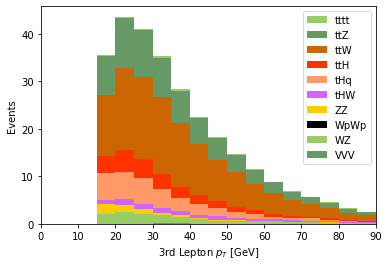

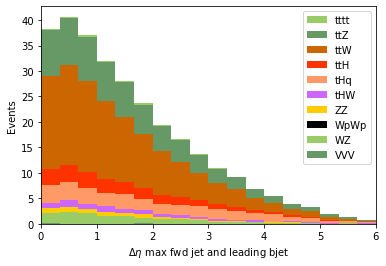

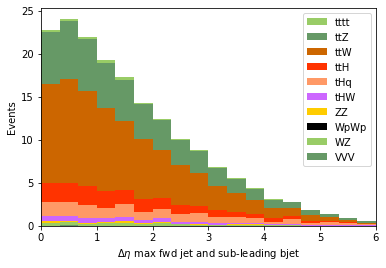

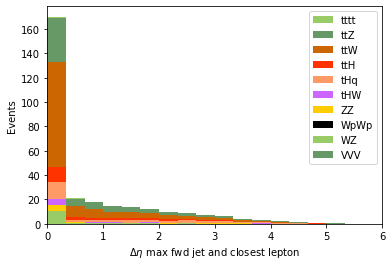

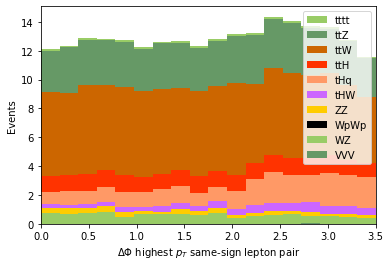

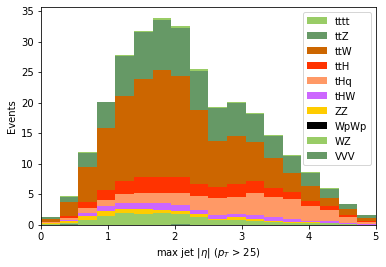

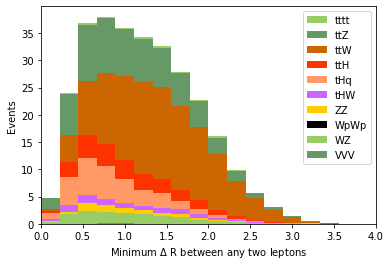

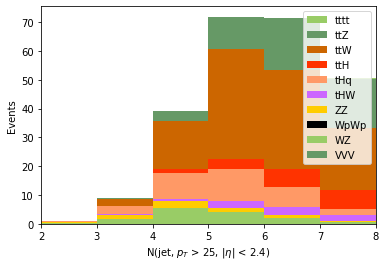

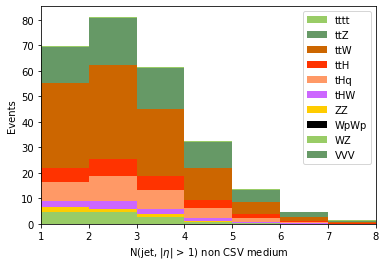

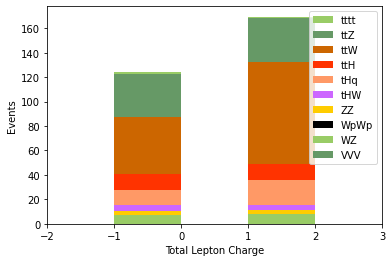

In [9]:
print('Three Lepton Channel')
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_3rdLepton_pT'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_fwdJet_leadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_fwdJet_subleadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_fwdJet_closestLepton'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_highpT_sslp'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_jetMaxEta'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_minDelR'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_NJetMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_NJetNONMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['lll_TotalCharge'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()

mu-mu Channel


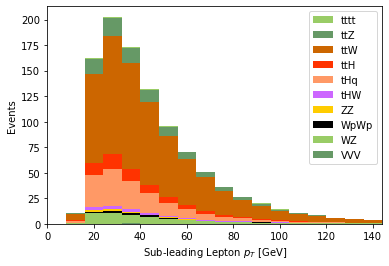

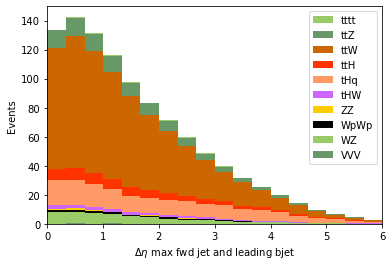

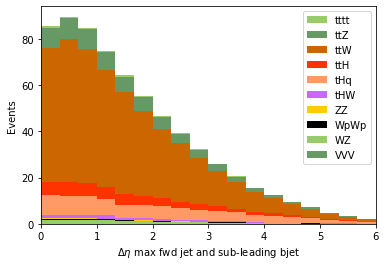

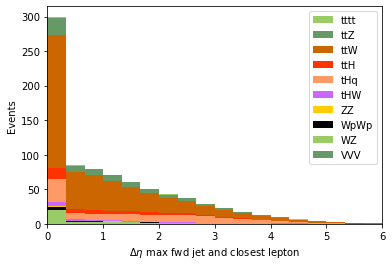

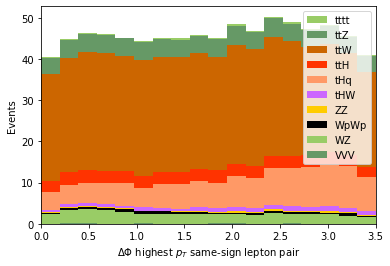

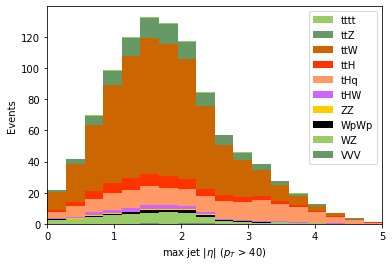

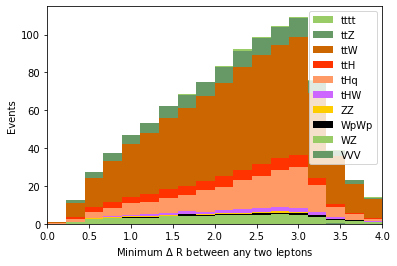

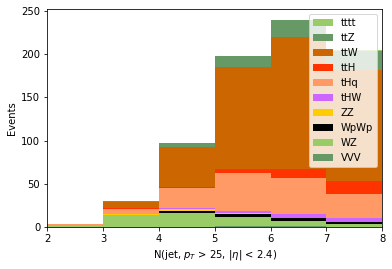

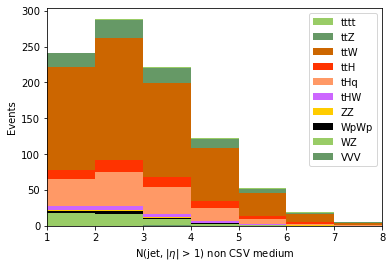

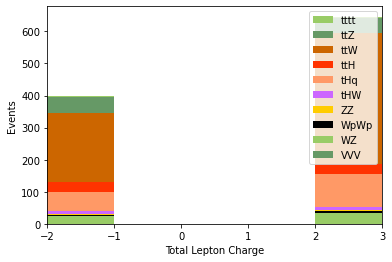

In [10]:
print('mu-mu Channel')
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_subleadLepton_pT'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_fwdJet_leadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_fwdJet_subleadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_fwdJet_closestLepton'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_highpT_sslp'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_jetMaxEta'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_minDelR'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_NJetMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_NJetNONMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['mumu_TotalCharge'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()

e-mu Channel


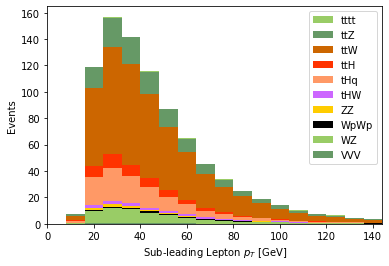

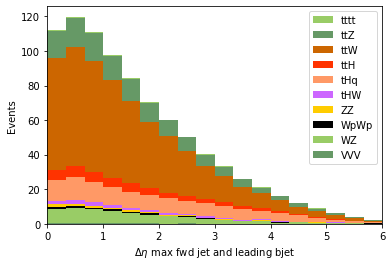

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


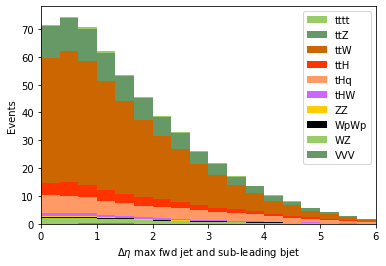

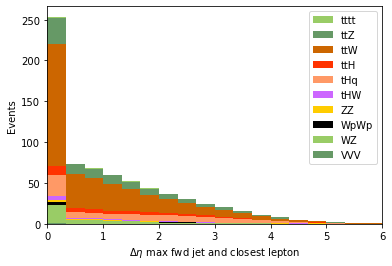

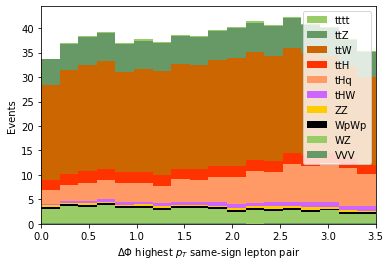

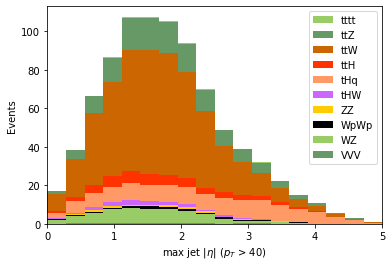

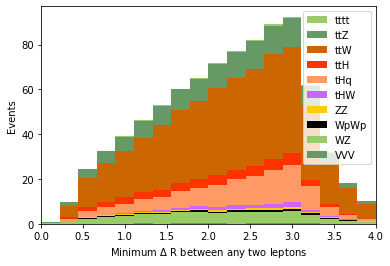

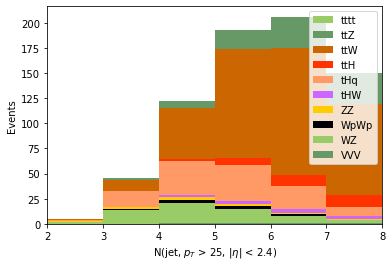

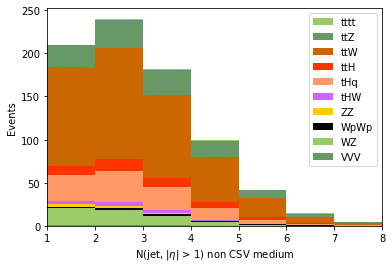

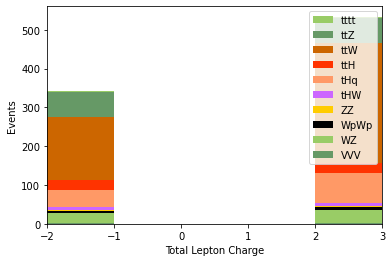

In [11]:
print('e-mu Channel')
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_subleadLepton_pT'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_fwdJet_leadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_fwdJet_subleadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_fwdJet_closestLepton'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_highpT_sslp'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_jetMaxEta'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_minDelR'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_NJetMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_NJetNONMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['emu_TotalCharge'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()

e-e Channel


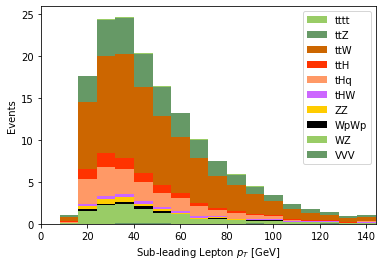

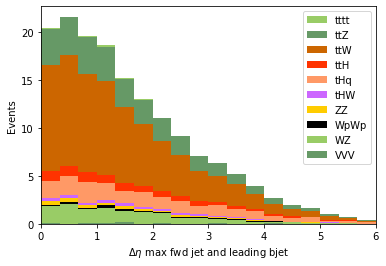

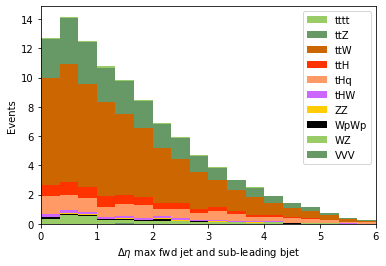

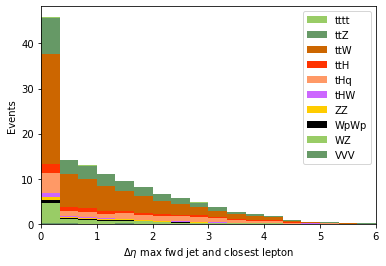

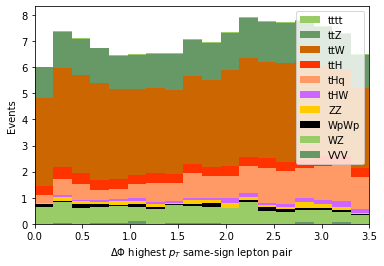

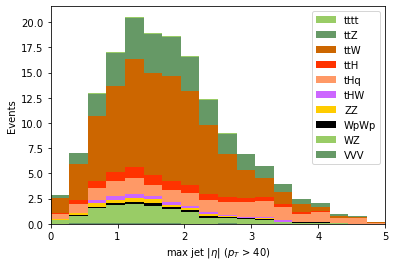

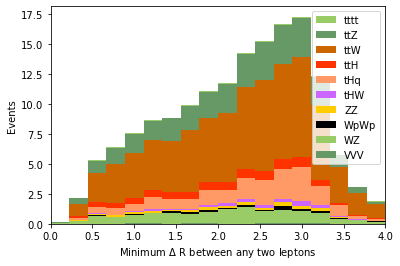

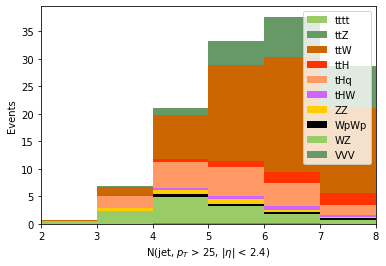

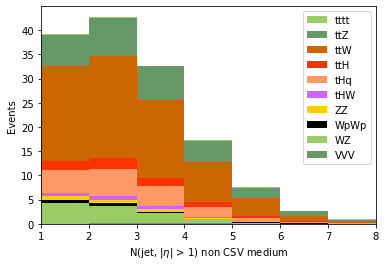

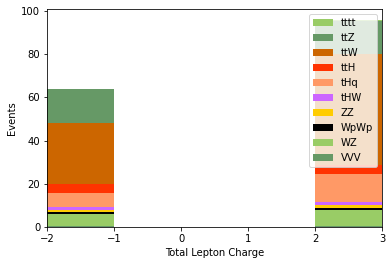

In [12]:
print('e-e Channel')
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_subleadLepton_pT'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_fwdJet_leadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_fwdJet_subleadbJet'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_fwdJet_closestLepton'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_highpT_sslp'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_jetMaxEta'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_minDelR'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_NJetMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_NJetNONMED'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()
fig, ax = plt.subplots(1)
ax.set_prop_cycle(cycler(color=colors))
hist.plot1d(output[0]['ee_TotalCharge'], overlay=overlay, stack=stack, ax=ax, clear=clear, fill_opts=fill_opts)
ax.set_ylim(0, None)
ax.legend()

In [13]:
for key, value in output[0]['cutflow'].items():
    print(key, value)

all events 116386751
passing 83518
